<a href="https://colab.research.google.com/github/AndrewGavluk/PythonML/blob/main/U_net_sample_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Подготавливаем параметры
## 1.1 Подключаем библиотеки

In [ ]:
%matplotlib inline
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
from IPython.display import Image
from random import uniform
from google.colab import files


from keras.layers import Input, Conv2D, Lambda, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import random

## 1.2 Загружаем файлы 

In [ ]:
uploaded = files.upload()

##1.3 Устанавливаем значения нач параметров

In [ ]:
HETGHT = 384 
WIDTH = 512

X1crop =28
X2crop =540
Y1crop =20
Y2crop =404

PICTURES=12
ADDITION_CHANELS = 1 # one for each dish
VARIENTY = 100 # rescaled copies of picture
IMG_CHANNELS = 3

BATCH_SIZE      = 24
NUM_EPOCHS      = 10
LR              = 1e-4
validation_split= 0.1

# learning rate
LR = 1e-4

# 2 Подготавливаем функции
## 2.1 getPicture

Предназначена для считывания картинки и получения массива

In [ ]:
# read picture from imgName return array
def getPicture (imgName,     # picture to read 
                pict=False,  # enable if RGB-picture disable if mask 
                show=False): # enable to see your picture
   
    # load image as as grayscale
    if show: 
      print(imgName)
    preImg = load_img(imgName, grayscale=False)
    img=preImg.crop((28,20,540,404))
    
    # convert image to a numpy array
    img_array256 = img_to_array(img)
    img_array = img_array256 / 256
    
    #set Ndim if RGB-Piture Ndim=3 else it is mask Ndim=1
    if pict:
      train_image = np.tile(img_array[:, :, 0][:, :, np.newaxis], (1, 1, 3))
      if show: 
        plt.imshow(train_image[0:HETGHT, 0:WIDTH])
    else:
      train_image = np.tile(img_array[:, :, 0][:, :, np.newaxis], (1, 1, 1))
      
      
    return train_image



## 2.2 loadImgAndMasks
Предназначена для создания "большой картинки" - картинки из RGB каналов и масок каждого из блюд

In [ ]:
# read "small image" and masks then concatenate it "big image" 
def loadImgAndMasks (imgNames,    # image and masks name
                     show=False):
    
    # load image
    picture = getPicture (imgNames[0], True, show)
    if show:
        print("picture.shape = ", picture.shape)
    else: 
        print ("processing ", imgNames[0])
       
  
    for i in range(ADDITION_CHANELS):
      # load mask
      mask = getPicture (imgNames[i+1], False, show)
      if show:
        print("mask" + str(i+1) + ".shape   = ", mask.shape)
      picture=np.concatenate([picture, mask], axis=2)
        
    return picture

## 3.1 generateBatch
Генерируем батч разнообразия

In [ ]:

def generatePicture (datagen, maskshow, parameters):
      newPictures255=datagen.apply_transform(maskshow, transform_parameters=parameters)
      newPictures=newPictures255/255
      return newPictures 


def showPicture (fig, rows, cols, i, pic):
      
      ax = fig.add_subplot(rows, cols, i )
      ax.grid('off')
      ax.axis('on') 
      ax.imshow(pic[0:HETGHT, 0:WIDTH])


def generateBatch (masksPictures,
                   iShow=0):      # Shows how much pictures will show in batch 

    
    datagen = ImageDataGenerator()

    cols = ADDITION_CHANELS + 1
    rows = VARIENTY
    fig = plt.figure(figsize=(5 * cols - 1, 5 * rows - 1))
    
    for i in range(VARIENTY):
      
      # define random generator parametrs 
      parameters={'theta':uniform(-45, 45), 'brightness':1.0, 'zx':uniform(0.5, 1.5), 'zy':uniform(0.5, 1.5), 'shear':uniform(-25, 25)}
      
      # change picture with params
      maskshow=masksPictures[:,:,0:3]
      newPicture = generatePicture (datagen, maskshow, parameters)
      if  i<iShow: 
        showPicture (fig, rows, cols, i*5+1, newPicture)

      for j in range(ADDITION_CHANELS):
          
          # change masks with params
          mask=masksPictures[:, :, 3+j:4+j]
          
          if i<iShow:
            maskshow = np.tile(mask[:, :, 0][:, :, np.newaxis], (1, 1, 3))
            newMask = generatePicture (datagen, maskshow, parameters)
            showPicture (fig, rows, cols, i*5+j+2, newMask)
          
          maskshow = np.tile(mask[:, :][:, :], (1, 1))
          newMask = generatePicture (datagen, maskshow, parameters)
          
          # add next chanel to picture 
          newPicture=np.concatenate([newPicture, newMask], axis=2)
       
      # produce 4d tensor 
      if i==0:
        # add 4-th dim to 3-d tensor
        oldBatch = np.expand_dims(newPicture, 0)  
      else:
        newPicture = np.expand_dims(newPicture, 0)
        oldBatch=np.concatenate([oldBatch, newPicture], axis=0)
      #print("oldBatch.shape=", oldBatch.shape) 
      
    return oldBatch

Train1_1.jpg
picture.shape =  (384, 512, 3)
Train1_1_1.gif
mask1.shape   =  (384, 512, 1)


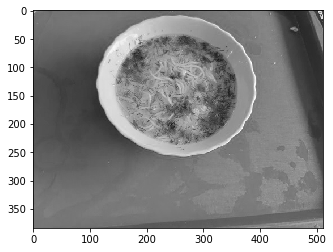

In [ ]:

trainList = list()
trainList.append("Train1_1.jpg")
trainList.append("Train1_1_1.gif")
Train1_1 = loadImgAndMasks(trainList, True)


## 3.2 Проверка работы generateBatch

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


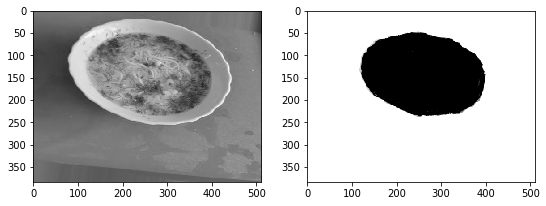

In [ ]:
Train1_1Batch = generateBatch(Train1_1, True)

## 4.1 Генерация

In [ ]:
#batch = 0
def genDataset():
  for i in range(1, 5):    # dish cycle 
    for j in range(1, 4):  # "big picture" cycle
    
    # list of filenames for "big picture"
      sMasks = list()
      sPicture = "Train" + str(i) + "_" + str(j) + ".jpg"
      sMasks.append(sPicture)

      name = "Train" + str(i) + "_" + str(j) + "_" + str(i) + ".gif"
      sMasks.append(name)
    
      bigPicture = loadImgAndMasks(sMasks) 
    
      if i==1 and j==1:
        batch = generateBatch(bigPicture)
      else:
        new_batch = generateBatch(bigPicture)
        batch = np.concatenate([batch, new_batch], axis=0) 
      print(batch.shape)
    
  return batch; 

# 4. Подготовка датасета

In [ ]:
Dataset =genDataset()
print(Dataset.shape)

processing  Train1_1.jpg
(100, 384, 512, 4)
processing  Train1_2.jpg
(200, 384, 512, 4)
processing  Train1_3.jpg
(300, 384, 512, 4)
processing  Train2_1.jpg
(400, 384, 512, 4)
processing  Train2_2.jpg
(500, 384, 512, 4)
processing  Train2_3.jpg
(600, 384, 512, 4)
processing  Train3_1.jpg
(700, 384, 512, 4)
processing  Train3_2.jpg
(800, 384, 512, 4)
processing  Train3_3.jpg
(900, 384, 512, 4)
processing  Train4_1.jpg
(1000, 384, 512, 4)
processing  Train4_2.jpg
(1100, 384, 512, 4)
processing  Train4_3.jpg
(1200, 384, 512, 4)
(1200, 384, 512, 4)


<Figure size 648x35928 with 0 Axes>

<Figure size 648x35928 with 0 Axes>

<Figure size 648x35928 with 0 Axes>

<Figure size 648x35928 with 0 Axes>

<Figure size 648x35928 with 0 Axes>

<Figure size 648x35928 with 0 Axes>

<Figure size 648x35928 with 0 Axes>

<Figure size 648x35928 with 0 Axes>

<Figure size 648x35928 with 0 Axes>

<Figure size 648x35928 with 0 Axes>

<Figure size 648x35928 with 0 Axes>

<Figure size 648x35928 with 0 Axes>

## 4.2 Перемешивание

In [ ]:

mixedDataset = Dataset
for i in range(VARIENTY*PICTURES):
  i1= i // PICTURES
  i2= i %  PICTURES
  mixedDataset[i, :, :, :] = Dataset[i2*VARIENTY+i1, :, :, :]
print(mixedDataset.shape)
  
# 
xTrain = mixedDataset[:,:,:,0:3]
yTrain = mixedDataset[:,:,:,3:4]

# inverting masks
yTrain = 1.-yTrain 
yTrain = (yTrain > 0.9)

print(xTrain.shape)
print(yTrain.shape)

(1200, 384, 512, 4)
(1200, 384, 512, 3)
(1200, 384, 512, 1)


## 4.3 Проверка

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


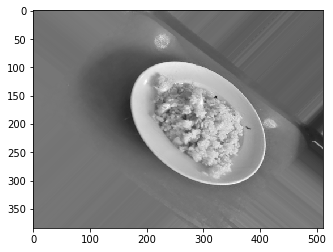

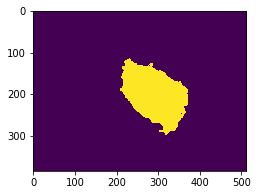

In [ ]:
Numb = 51

maskSample = xTrain[Numb, :,:,:]
plt.imshow(maskSample[0:HETGHT, 0:WIDTH])

fig = plt.figure(figsize=(25, 10))

pic=yTrain[Numb, :,:,0]
showPicture (fig, 3, 4, 5, pic)

# 5.Обучаем нейросеть
## 5.1 Собираем нейросеть


In [ ]:
DropoutL1 = 0.85
DropoutL2 = 0.90
DropoutL3 = 0.95

# Build U-Net model
inputs = Input((HETGHT, WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x ) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(DropoutL1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(DropoutL1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(DropoutL2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(DropoutL2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization() (c5)
c5 = Dropout(DropoutL3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(DropoutL2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(DropoutL2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(DropoutL1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(DropoutL1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
optimizer = Adam(lr=LR,)
model.compile(optimizer=optimizer, loss='binary_crossentropy',)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 384, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 384, 512, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 384, 512, 16) 448         lambda_8[0][0]                   
__________________________________________________________________________________________________
dropout_64 (Dropout)            (None, 384, 512, 16) 0           conv2d_134[0][0]                 
____________________________________________________________________________________________

## 5.2 Обучаем нейросеть

In [ ]:
# Fit model
history = model.fit(xTrain, yTrain, 
                    validation_split=validation_split, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    verbose=1)

Train on 1080 samples, validate on 120 samples
Epoch 1/100
1080/1080 [==============================] - 73s 68ms/step - loss: 5.5080 - val_loss: 0.7975
Epoch 2/100
1080/1080 [==============================] - 68s 63ms/step - loss: 3.3149 - val_loss: 0.6019
Epoch 3/100
1080/1080 [==============================] - 68s 63ms/step - loss: 1.4206 - val_loss: 0.5268
Epoch 4/100
1080/1080 [==============================] - 68s 63ms/step - loss: 1.1142 - val_loss: 0.5416
Epoch 5/100
1080/1080 [==============================] - 68s 63ms/step - loss: 0.9660 - val_loss: 0.6268
Epoch 6/100
1080/1080 [==============================] - 68s 63ms/step - loss: 0.8648 - val_loss: 0.6664
Epoch 7/100
1080/1080 [==============================] - 68s 63ms/step - loss: 0.7900 - val_loss: 0.7244
Epoch 8/100
1080/1080 [==============================] - 68s 63ms/step - loss: 0.7318 - val_loss: 0.7388
Epoch 9/100
1080/1080 [==============================] - 69s 63ms/step - loss: 0.6845 - val_loss: 0.7860
Epoch 10

KeyboardInterrupt: ignored

In [ ]:
model.save('keras_unet.h5')

## 5.3 Функция потерь

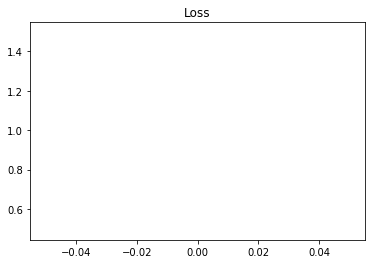

In [ ]:
def plot_loss_history(history):
    # validation losses
    val_loss = history.history['val_loss']
    loss = history.history['loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.show()
    
plot_loss_history(history)

In [ ]:
yPredict = model.predict(xTrain, verbose=1)
yPredict.shape

1200/1200 [==============================] - 26s 22ms/step


(1200, 384, 512, 1)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


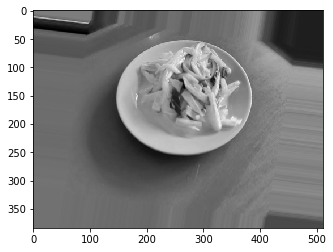

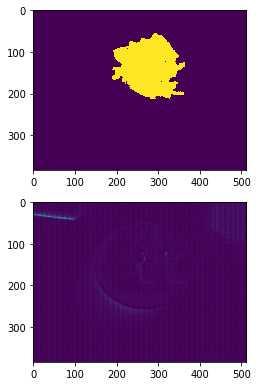

In [ ]:
Numb=45

maskSample = xTrain[Numb, :,:,:]
plt.imshow(maskSample[0:HETGHT, 0:WIDTH])

fig = plt.figure(figsize=(25, 10))

pic=yTrain[Numb, :,:,0]
showPicture (fig, 3, 4, 5, pic)


pic=yPredict[Numb, :,:,0]
showPicture (fig, 3, 4, 9, pic)
